## Setup

### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torchaudio

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Audio, display, Image

### Colab and Google Drive Setup (If applicable)

In [ ]:
in_colab = False

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    in_colab = True

except:
    pass 

if in_colab:
    # Main project directory location
    PROJECT_DIR = 'project-ceti/'
    
    BASE_DIR= os.path.join('/content/drive/', 
                           'My Drive/',
                           PROJECT_DIR)
    
    #Save extracted data here
    RAW_DATA_DIR= BASE_DIR+ "data"

    #Save images here
    IMAGE_DIR = BASE_DIR+ "images/"

    # Save pickle file here
    FILE_PATH = BASE_DIR+'data.csv'
    
    print(os.listdir(BASE_DIR))
    os.chdir(BASE_DIR)

In [4]:
print("Total # of Files: ", len(os.listdir(RAW_DATA_DIR)))

Total # of Files:  1024


#### Extract Data (only needed to run once)

In [ ]:
# !tar -zxvf data.tar.gz

## Part 1: Data Processing

#### Organize Data

In [5]:
#get audio paths
audio_paths, filenames, labels = [], [], []

for path, dir, files in os.walk(RAW_DATA_DIR):
    for file in files:
        audio_paths.append(str(path) + '/' + str(file))
        filenames.append(file)
        labels.append(file.split("_")[0])

In [6]:
data = pd.DataFrame()
data['file'] =files
data['label'] = labels
data['id'] = data.index
data['path'] = audio_paths

display(data)

,file,label,id,path
0,a_7.wav,a,0,/content/drive/My Drive/project-ceti/data/a_7.wav
1,a_22.wav,a,1,/content/drive/My Drive/project-ceti/data/a_22...
2,a_57.wav,a,2,/content/drive/My Drive/project-ceti/data/a_57...
3,a_27.wav,a,3,/content/drive/My Drive/project-ceti/data/a_27...
4,a_90.wav,a,4,/content/drive/My Drive/project-ceti/data/a_90...
...,...,...,...,...
1019,a_5.wav,a,1019,/content/drive/My Drive/project-ceti/data/a_5.wav
1020,a_25.wav,a,1020,/content/drive/My Drive/project-ceti/data/a_25...
1021,a_72.wav,a,1021,/content/drive/My Drive/project-ceti/data/a_72...
1022,a_107.wav,a,1022,/content/drive/My Drive/project-ceti/data/a_10...


In [ ]:
print(f"# of data from class'a' {len(data[data['label'] == 'a'])}")
print(f"# of data from class'b' {len(data[data['label'] == 'b'])}")

# of data from class'a' 512
# of data from class'b' 512


#### Helper Functions For Data Processing

In [43]:
import imageio

def load_audio(path):  
    """
    Load audio file and get the time-series data and sampling rate.
    params: 
    path: file path
    returns:
    y: audio time-series
    sr: sampling rate of y
    time: duration of clip in milliseconds
    """
    y, sr = librosa.load(path)

    # apply trim to remove silent edges
    y, _= librosa.effects.trim(y)

    # get duration
    time = librosa.get_duration(y=y, sr=sr)

    return y, sr, time*1000 #for milliseconds


def apply_padding(sig, sr, max_ms):
    """
    Apply padding to signal to get fixed-length signal
    params: 
      sig: signal data
      sr: sampling rate of y
      max_ms: maximum duration to keep in milliseconds
    returns:
      sig: Padded / Cropped signal
      sr: sampling rate
    """
    sig_len = len(sig)
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:max_len]

    elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = np.zeros(pad_begin_len)
        pad_end = np.zeros(pad_end_len)

        sig = np.pad(sig, (0, max_len - sig_len), "constant")

    return sig, sr

def get_mel_spectogram(y, sr=22050,
                       n_fft= 1024,  
                       hop_length=None, 
                       n_mels= 144):
   
    """
    Get Mel spectogram for the signal
    params: 
    y: signal data
    sr: sampling rate of y
    n_fft: width of the Spectrogram = Total number of samples / hop_length
    max_ms: maximum duration to keep in milliseconds
    hop_length: number of samples per time-step in spectrogram
    n-mels: number of bins in spectrogram. (height of spectogram)
    returns:
    S: Mel Spectogram

    """                       

    # Compute mel-scaled spectrogram
    S = librosa.feature.melspectrogram(y=y,
                                     sr=sr, 
                                     n_mels=n_mels, 
                                     hop_length= hop_length, 
                                     n_fft=n_fft, 
                                     )

    return S


def scale_minmax(data, min=0.0, max=1.0):
    """
    Apply min-max normalization to scale the data
    params: 
    data: data
    min: minimum
    max: maximum
    returns:
    data_scaled: Scaled data

    """              
    data_std = (data - np.min(data)) / (np.max(data) - np.min(data))
    data_scaled = data_std * (max - min) + min
    return data_scaled


def save_as_image(S, out):
    """
    Save spectogram as image
    params: 
    S: Spectogram

    returns:
    out: image output 
    """   
    # Convert to log scale with small epsilon
    S = np.log(S + 1e-9)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(S, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert, make black==more energy

    # save as PNG
    imageio.imwrite(out, img)


#Show digital representation of audio signal
def visualize_signal(y, sr, title="Signal", 
                     xlabel="Time (samples)", 
                     ylabel="Amplitude"):
    librosa.display.waveplot(y, sr=sr);
    plt.title(title);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);


def visualize_spectogram(y,
                         sr=22050,
                          n_fft= 1024,  
                          hop_length=512, 
                          n_mels= 144,
                          title="Spectogram",
                          x_axis="time",
                          y_axis='log'):

    # Compute mel-scaled spectrogram
    S = librosa.feature.melspectrogram(y=y,
                                     sr=sr, 
                                     n_mels=n_mels, 
                                     hop_length= hop_length, 
                                     n_fft=n_fft, 
                                     )
    S = librosa.power_to_db(S, ref=np.max)

    librosa.display.specshow(S, sr=sr, 
                           hop_length = hop_length,
                           x_axis=x_axis,
                           y_axis=y_axis)

    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

    # for mel spectogram, use these params
    # librosa.display.specshow(y, sr=sr, x_axis="Time", y_axis='Mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel Spectrogram')


#### Process Data and Get Mel Spectogram

In [ ]:
# Load all file names
data['file'] =  data.apply(lambda row : row['file'].split(".")[0],
                         axis = 1)

# load all samples
data['y'], data['sr'], data['time'] =  data.apply(lambda row: load_audio(row['path']),
                                    axis=1,
                                    result_type = 'expand').transpose().values


Get fixed length of all signals 
  - Using mean duration as the size of window. 
  - smaller clips to be padded 
  - bigger clips to be cropped

In [ ]:
## Setting window size to be == mean duration of audio clips
mean_time = int(np.mean(data['time']))

## For fixed length input, applying padding 
data['y_padded'], data['sr'] = data.apply(lambda row: apply_padding(row['y'], 
                                                        row['sr'], 
                                                        mean_time),
                                    axis=1,
                                    result_type = 'expand').transpose().values

Get Mel Spectogram for all signals

In [ ]:
data['mel_spec'] = data.apply(lambda row: 
                              get_mel_spectogram(row['y_padded'], row['sr']),
                              axis=1)

Save data as pickle file for future use

In [ ]:
data.to_pickle(FILE_PATH)

## Part 2 Data Exploration

In [8]:
data = pd.read_pickle(FILE_PATH)

In [9]:
data.head()

,file,label,id,path,y,sr,time,y_padded,mel_spec
0,a_7,a,0,/content/drive/My Drive/project-ceti/data/a_7.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1532.517007,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.02656238, 0.8633892, 0.86995596, 0.04..."
1,a_22,a,1,/content/drive/My Drive/project-ceti/data/a_22...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,441.179138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 5.8362344e-05, 0.31780607, 0.75718..."
2,a_57,a,2,/content/drive/My Drive/project-ceti/data/a_57...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,766.258503,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9.34657e-25, 0.3912533, 2.407149, 0.7333716,..."
3,a_27,a,3,/content/drive/My Drive/project-ceti/data/a_27...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,3041.814059,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.015122386, 1.4566083, 2.069294, ..."
4,a_90,a,4,/content/drive/My Drive/project-ceti/data/a_90...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1857.596372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.23137505, 1.9276781, 0.89243084, 0.00..."


In [10]:
len(data[data['time'] < 1000])

322

In [11]:
print(data['time'].min(), data['time'].max())

363.2199546485261 3993.8321995464853


In [13]:
data['mel_spec_shape'] = data.apply(lambda row: 
                             row['mel_spec'].shape,
                              axis=1)



In [14]:
data['mel_spec_shape'].min()

(144, 144)

In [15]:
data['mel_spec_shape'].max()

(144, 144)

In [16]:
data.tail()

,file,label,id,path,y,sr,time,y_padded,mel_spec,mel_spec_shape
1019,a_5,a,1019,/content/drive/My Drive/project-ceti/data/a_5.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,3157.913832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.18526593, 1.5418111, 0.65282273, 0.01...","(144, 144)"
1020,a_25,a,1020,/content/drive/My Drive/project-ceti/data/a_25...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,441.179138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 1.5943539e-05, 0.087750494, 0.2174...","(144, 144)"
1021,a_72,a,1021,/content/drive/My Drive/project-ceti/data/a_72...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,2159.455782,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.04572789, 0.70282006, 0.6002131,...","(144, 144)"
1022,a_107,a,1022,/content/drive/My Drive/project-ceti/data/a_10...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,417.959184,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.010184722, 0.35795125, 0.321037, 0.01...","(144, 144)"
1023,a_114,a,1023,/content/drive/My Drive/project-ceti/data/a_11...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,2182.675737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 2.9029465e-09, 0.064895496, 0.19688731,...","(144, 144)"


#### Checking a few samples from class a

In [31]:
# slice first 5 samples
samples_class_a = data[data['label']=='a'][:5]
samples_class_a

,file,label,id,path,y,sr,time,y_padded,mel_spec,mel_spec_shape
0,a_7,a,0,/content/drive/My Drive/project-ceti/data/a_7.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1532.517007,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.02656238, 0.8633892, 0.86995596, 0.04...","(144, 144)"
1,a_22,a,1,/content/drive/My Drive/project-ceti/data/a_22...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,441.179138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 5.8362344e-05, 0.31780607, 0.75718...","(144, 144)"
2,a_57,a,2,/content/drive/My Drive/project-ceti/data/a_57...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,766.258503,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9.34657e-25, 0.3912533, 2.407149, 0.7333716,...","(144, 144)"
3,a_27,a,3,/content/drive/My Drive/project-ceti/data/a_27...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,3041.814059,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.015122386, 1.4566083, 2.069294, ...","(144, 144)"
4,a_90,a,4,/content/drive/My Drive/project-ceti/data/a_90...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1857.596372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.23137505, 1.9276781, 0.89243084, 0.00...","(144, 144)"


In [33]:
Audio(data=samples_class_a['y'][0], 
      rate=samples_class_a['sr'][0])

In [34]:
Audio(data=samples_class_a['y'][2], 
      rate=samples_class_a['sr'][2])

In [35]:
Audio(data=samples_class_a['y'][4], 
      rate=samples_class_a['sr'][4])

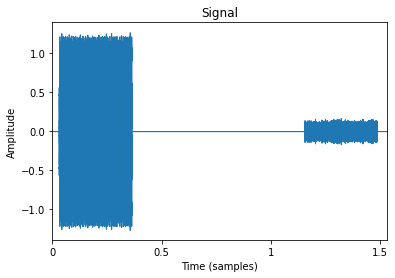

In [36]:
visualize_signal(samples_class_a['y'][0],
                 samples_class_a['sr'][0])

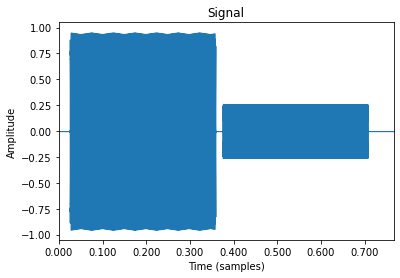

In [37]:
visualize_signal(samples_class_a['y'][2],
                 samples_class_a['sr'][2])

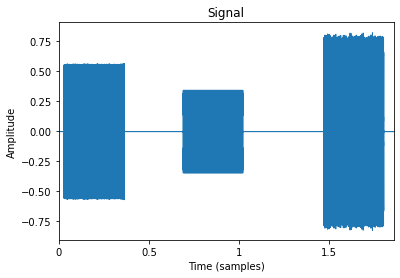

In [38]:
visualize_signal(samples_class_a['y'][4],
                 samples_class_a['sr'][4])

#### Visualize Mel Spectogram

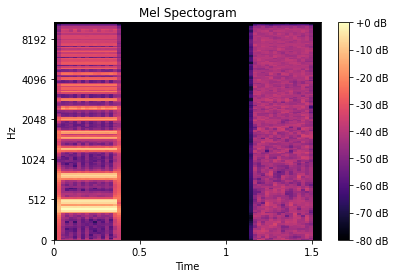

In [45]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_a['y'].iloc[0], 
                     samples_class_a['sr'].iloc[0],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

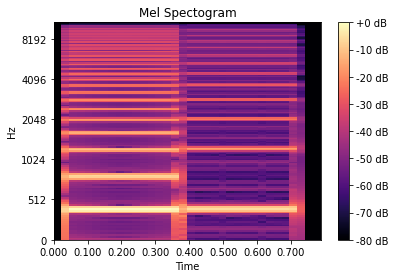

In [46]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_a['y'][2], 
                     samples_class_a['sr'][2],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

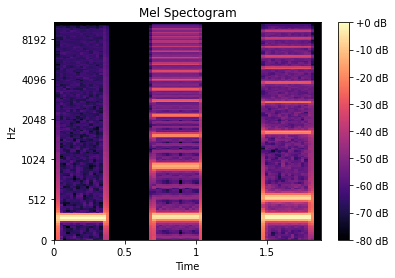

In [48]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_a['y'][4], 
                     samples_class_a['sr'][4],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

#### Checking a few samples from class b

In [49]:
# slice first 5 samples
samples_class_b = data[data['label']=='b'][:5]
samples_class_b

,file,label,id,path,y,sr,time,y_padded,mel_spec,mel_spec_shape
320,b_18,b,320,/content/drive/My Drive/project-ceti/data/b_18...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,2600.634921,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 8.1346025e-06, 0.024171673, 0.13497855,...","(144, 144)"
323,b_26,b,323,/content/drive/My Drive/project-ceti/data/b_26...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1787.936508,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 4.1256103e-06, 0.11860555, 0.36479...","(144, 144)"
325,b_14,b,325,/content/drive/My Drive/project-ceti/data/b_14...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,2507.755102,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[2.537639e-25, 0.24069527, 1.7429929, 0.73695...","(144, 144)"
328,b_7,b,328,/content/drive/My Drive/project-ceti/data/b_7.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,417.959184,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 8.2959445e-22, 0.00015081627, 0.0086652...","(144, 144)"
333,b_13,b,333,/content/drive/My Drive/project-ceti/data/b_13...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,1300.31746,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.05958774, 0.55417037, 0.28522697, 0.0...","(144, 144)"


In [50]:
Audio(data=samples_class_b['y'].iloc[0], 
      rate=samples_class_b['sr'].iloc[0])

In [51]:
Audio(data=samples_class_b['y'].iloc[2], 
      rate=samples_class_b['sr'].iloc[2])

In [52]:
Audio(data=samples_class_b['y'].iloc[4], 
      rate=samples_class_b['sr'].iloc[4])

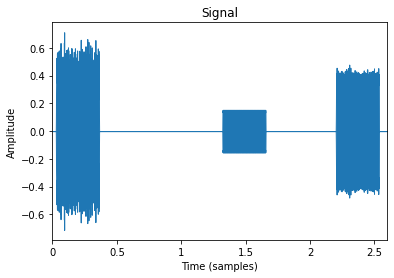

In [53]:
visualize_signal(samples_class_b['y'].iloc[0],
                 samples_class_b['sr'].iloc[0])

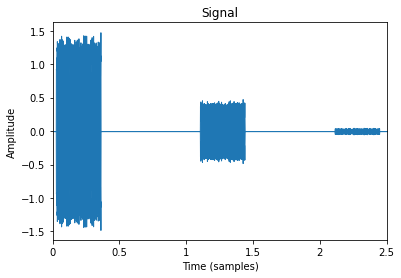

In [54]:
visualize_signal(samples_class_b['y'].iloc[2],
                 samples_class_b['sr'].iloc[2])

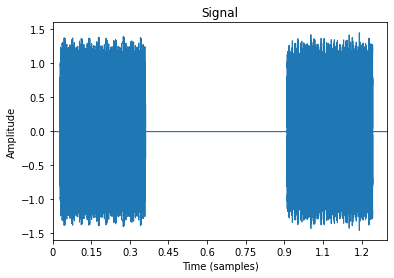

In [55]:
visualize_signal(samples_class_b['y'].iloc[4],
                 samples_class_b['sr'].iloc[4])

#### Visualize Mel Spectogram

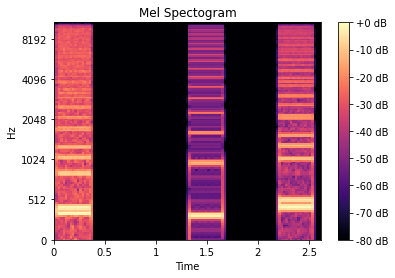

In [56]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_b['y'].iloc[0], 
                     samples_class_b['sr'].iloc[0],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

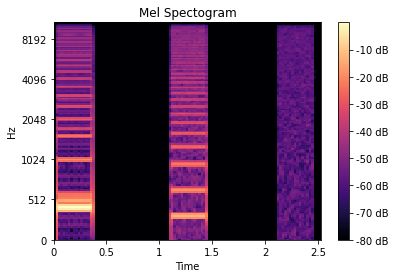

In [57]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_b['y'].iloc[2], 
                     samples_class_b['sr'].iloc[2],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

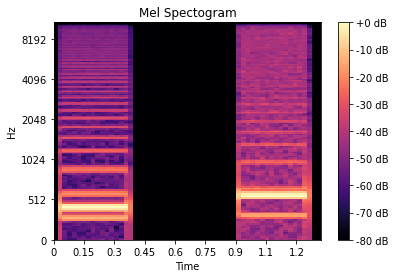

In [58]:
# Visualize Mel Spectogram in Mel Scale
visualize_spectogram(samples_class_b['y'].iloc[4], 
                     samples_class_b['sr'].iloc[4],  
                     y_axis='mel',
                     title= "Mel Spectogram"
                     )

## Part 3: Dataloaders, Model Training, and Evaluation

#### Imports

In [59]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import torch
import torchvision
# import torchaudio # not used could be used in place of Librosa library for part 1

from torchvision import transforms
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split, Subset

from torch import nn
import torch.nn.functional as F

import torch.optim as optim
from torchinfo import summary

import math
from collections import OrderedDict

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Hyperparameters

In [62]:
BATCH_SIZE = 16
LR = 0.001 #learning rate
WD = 0.0001 #weight decay

EPOCHS = 100

In [127]:
# Other constants
INPUT_DIM = (1, 1, 64, 64) #NOTE: IMAGE OF 144 by 144 is resized to 64 by 64 in dataloader
OUTPUT_DIM = 2

#### Prepare Training, Test, & Validation Dataset

##### Directory setup

Save images of mel spectogram for training

In [128]:
## Read data from saved file
data = pd.read_pickle(FILE_PATH)

Save as Image

In [129]:
# # Save mel spectogram data as image
# data.apply(lambda row: save_as_image(row['mel_spec'],
#                                      out= IMAGE_DIR+ row['file']+'.png'),
#                               axis=1)

Set up subdirectories for each class for pytorch dataloader by Image Folder

In [130]:
len(os.listdir(IMAGE_DIR))

1024

In [66]:
dest_dir = BASE_DIR+"img/"
dest_dir_a = BASE_DIR+"img/a/"
dest_dir_b = BASE_DIR+"img/b/"

print(len(os.listdir(IMAGE_DIR)))
print(len(os.listdir(dest_dir_a)))
print(len(os.listdir(dest_dir_b)))

1024
512
512


Copy files to corresponding directory for its class (only run once)

In [ ]:
# import shutil

# for path, dir, files in os.walk(IMAGE_DIR):
#   print(files)
#   for file in files:
#     label = file.split("_")[0]

#     if label == 'a':
#       src = os.path.join(IMAGE_DIR, file)
#       dest = os.path.join(dest_dir_a, file)
#       shutil.copyfile(src, dest) if not os.path.isdir(src) else print("Not a filepath")
      
#     elif label == 'b':
#       src = os.path.join(IMAGE_DIR, file)
#       dest = os.path.join(dest_dir_b, file)

#       shutil.copyfile(src, dest) if not os.path.isdir(src) else print("Not a filepath")

# print(len(os.listdir(IMAGE_DIR)))
# print(len(os.listdir(dest_dir_a)))
# print(len(os.listdir(dest_dir_b)))

['a_59.png', 'a_19.png', 'a_98.png', 'a_43.png', 'a_78.png', 'a_41.png', 'a_87.png', 'a_95.png', 'a_58.png', 'a_76.png', 'a_29.png', 'a_34.png', 'a_103.png', 'a_64.png', 'a_83.png', 'a_96.png', 'a_36.png', 'a_48.png', 'a_75.png', 'a_65.png', 'a_99.png', 'a_109.png', 'a_49.png', 'a_111.png', 'a_33.png', 'a_0.png', 'a_88.png', 'a_52.png', 'a_44.png', 'a_51.png', 'a_81.png', 'a_39.png', 'a_86.png', 'a_102.png', 'a_54.png', 'a_68.png', 'a_79.png', 'a_11.png', 'a_63.png', 'a_106.png', 'a_70.png', 'a_104.png', 'a_105.png', 'a_30.png', 'a_55.png', 'a_92.png', 'a_100.png', 'a_24.png', 'a_13.png', 'a_112.png', 'a_42.png', 'a_8.png', 'a_85.png', 'a_37.png', 'a_28.png', 'a_60.png', 'a_16.png', 'a_53.png', 'a_32.png', 'a_80.png', 'a_91.png', 'a_89.png', 'a_47.png', 'a_12.png', 'a_23.png', 'a_93.png', 'a_17.png', 'a_238.png', 'a_299.png', 'a_128.png', 'a_201.png', 'a_288.png', 'a_167.png', 'a_180.png', 'a_190.png', 'a_267.png', 'a_199.png', 'a_317.png', 'a_205.png', 'a_228.png', 'a_215.png', 'a_221

##### Data Loader Setup

Prepare Training, Testing, & Validation Dataloaders

In [131]:
dest_dir = BASE_DIR+"img/"


# Compose all data transformations 
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)), #Resize to smaller size image
    transforms.ToTensor(), # convert to tensor,
    transforms.RandomHorizontalFlip(), #Applying random horizontal flips
    transforms.Normalize(0.5, 0.5) #Probably not needed in this case since data was already normalized
])

# Get dataset from the root directory
dataset = torchvision.datasets.ImageFolder(root= dest_dir, 
                                          transform= data_transforms)

## Apply 80|20 split 
total_count = 1024 # total size of data
train_count = int(0.8 * total_count)
test_count  = total_count - train_count 



train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_count,  
                                                                            test_count]
                                                                           )

train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=BATCH_SIZE, 
                                                   shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=True)

dataloaders = {
    "train": train_loader,
    "test": test_loader}

x,y = next(iter(dataloaders['train']))

print(x.shape, y.shape)

torch.Size([16, 1, 64, 64]) torch.Size([16])


In [132]:
print(f" Dataset Size:\n Training Data: {len(train_dataset)}\n Test Data: {len(test_dataset)}")

 Dataset Size:
 Training Data: 819
 Test Data: 205


Displaying the loaded dataset

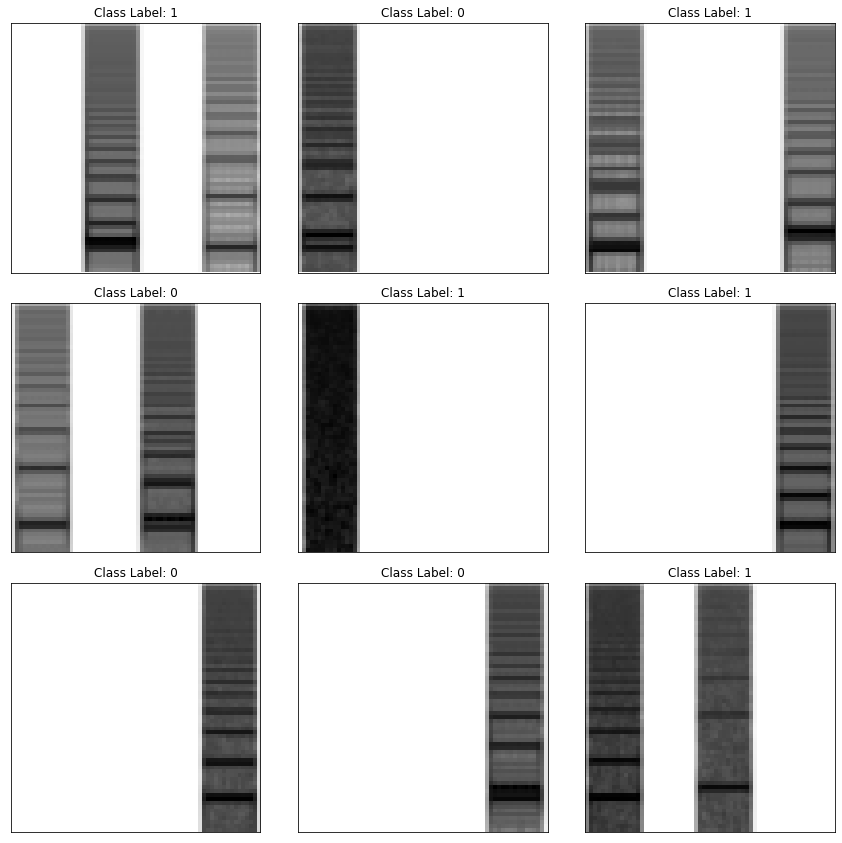

In [133]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))  #figsize=(8,8)
for i in range(9):
  plt.subplot(3,3, i+1)
  plt.tight_layout()
  plt.imshow(train_dataset[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_dataset[i][1]))
  plt.xticks([])
  plt.yticks([])



In [134]:
print("Input Shape: ", train_dataset[0][0].shape)

Input Shape:  torch.Size([1, 64, 64])


## Model

Define the Model: 

- For my first iteration, I have chosen a CNN architecture and converted the spectogram as images as an input to the model
- Since this is a classification problem, I a using Cross-entropy loss as the loss function
- As an optimizer, I'm using Adam's optimizer to help make faster updates in case of a smooth gradient
- Other techniques tried: Batch normalization to normalize the internal signals and improve the geometry of learning
- Drop out to reducer overfitting and help the model generalize better
- Weight decay to encourage smaller params

In [136]:
from torch import nn

#Define a conv2d block with conv 2d layer, batch norm layer, relu, maxpooling, and dropout layers
class Conv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, pooling=2, dropout=0.01):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, padding=kernel_size//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out


class BinaryClassifier(nn.Module):
    
    def __init__(self, num_channels=1, num_classes=2):
    super(BinaryClassifier, self).__init__()
    conv_layers = []

    self.input_bn = nn.BatchNorm2d(1)

    # Convolutional layers 
    # 1 input image channel, 8 output channels, 3x3 square convolution kernel, 2 x 2 max pooling
    self.conv1 = Conv2d(1, 8, pooling=(2,2))
    # 8 input image channel, 16 output channels, rest same as above
    self.conv2 = Conv2d(8, 16, pooling=(2,2))
    # 16  input image channel, 32 output channels
    self.conv3 = Conv2d(16, 32, pooling=(2,2))
    # 32 input image channel, 64 output channels 
    self.conv4 = Conv2d(32, 64, pooling=(2,2))


    # fully connected layers
    self.fc1 = nn.Linear(1024, 16)
    self.fc_bn = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(16, 2)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()


    def forward(self, x):
        # out = x.unsqueeze(1)
        # batch norm
        out = self.input_bn(x)

        # convolutional layers
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # fully connected layers
        out = self.fc1(out)
        out = self.fc_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return F.log_softmax(out, dim=1)


#### Instantiate the Binary Classifier

In [137]:
conv_net = BinaryClassifier()

#### Model Summary

In [138]:
from torchinfo import summary
summary(conv_net, input_size=INPUT_DIM)

Layer (type:depth-idx)                   Output Shape              Param #
BinaryClassifier                         [1, 2]                    --
├─BatchNorm2d: 1-1                       [1, 1, 64, 64]            2
├─Conv2d: 1-2                            [1, 8, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
│    └─ReLU: 2-3                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-4                    [1, 8, 32, 32]            --
│    └─Dropout: 2-5                      [1, 8, 32, 32]            --
├─Conv2d: 1-3                            [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           1,168
│    └─BatchNorm2d: 2-7                  [1, 16, 32, 32]           32
│    └─ReLU: 2-8                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 16, 16, 16]           --
│    └─Dropou

### Define Helper Functions

#### Function to train the model

In [139]:
def train_model(model, train_loader, device, loss_fn, optimizer, input_dim= INPUT_DIM):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader 
    for images, labels in train_loader:
        # reshape input
        images = torch.reshape(images,input_dim)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        # Append the training loss 
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

#### Function to test the model

In [140]:
# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=INPUT_DIM):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Defining the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshaping input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            
            ## predict the label
            pred = model(images)
            
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
            
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

In [144]:
### Setting the random seed for reproducible results
torch.manual_seed(10)

# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def weight_init_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 0.0)
        m.bias.data.fill_(0.01)

def weight_init_xavier(m):
    '''
    Xavier uniform initialization
    '''
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain('relu'))   

Selected device: cuda


In [145]:
conv_net.to(device)

BinaryClassifier(
  (input_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(
    (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (conv2): Conv2d(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (conv3): Conv2d(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [146]:
# weight initialization
conv_net.apply(weight_init_zero)

# Applying the xavier weight initialization
conv_net.apply(weight_init_xavier)

params_to_optimize_conv = [
    {'params': conv_net.parameters()}
]

### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= LR

optim_conv = torch.optim.Adam(params_to_optimize_conv, lr=lr, weight_decay=1e-05)
num_epochs = EPOCHS

### Training the Classifier

In [147]:
import datetime

print('Conv Net training started')
history_conv = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    train_loss = train_model(
        model=conv_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_conv,
        input_dim=(-1,1,64,64))
    
    ### Validation
    val_loss = test_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,64,64))
    
    # Printing Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_conv['train_loss'].append(train_loss)
    history_conv['val_loss'].append(val_loss)

    # Saving the model
    if np.argmin( history_conv['val_loss']) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(conv_net.state_dict(), BASE_DIR+"model/"+'best_model.ckpt')


print(f'Conv Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

Conv Net training started
Epoch 1/100 : train loss 0.992 	 val loss 0.734
Saving the best model at 0 epochs!
Epoch 2/100 : train loss 0.826 	 val loss 0.627
Saving the best model at 1 epochs!
Epoch 3/100 : train loss 0.731 	 val loss 0.584
Saving the best model at 2 epochs!
Epoch 4/100 : train loss 0.676 	 val loss 0.545
Saving the best model at 3 epochs!
Epoch 5/100 : train loss 0.669 	 val loss 0.525
Saving the best model at 4 epochs!
Epoch 6/100 : train loss 0.631 	 val loss 0.510
Saving the best model at 5 epochs!
Epoch 7/100 : train loss 0.554 	 val loss 0.549
Epoch 8/100 : train loss 0.580 	 val loss 0.593
Epoch 9/100 : train loss 0.566 	 val loss 0.485
Saving the best model at 8 epochs!
Epoch 10/100 : train loss 0.543 	 val loss 0.447
Saving the best model at 9 epochs!
Epoch 11/100 : train loss 0.484 	 val loss 0.492
Epoch 12/100 : train loss 0.465 	 val loss 0.457
Epoch 13/100 : train loss 0.478 	 val loss 0.655
Epoch 14/100 : train loss 0.486 	 val loss 0.459
Epoch 15/100 : tr

### Visualizing Training Progress of The Classifier

Text(0, 0.5, 'Cross Entropy Loss')

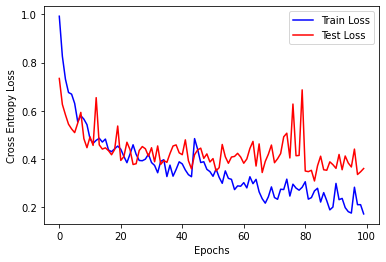

In [148]:
fig = plt.figure()
plt.plot(history_conv['train_loss'], color='blue')
plt.plot(history_conv['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

### Visualizing Predictions of Classifer

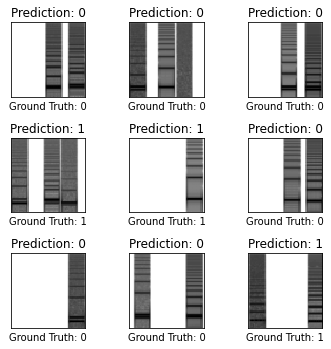

In [149]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = conv_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.xlabel("Ground Truth: {}".format(example_targets.cpu().detach().numpy()[i]))
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

#### Evaluating the Model on the Test Data

In [206]:

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score 

# Evaluation Function
def evaluate_model(model, test_loader, device, loss_fn, input_dim=INPUT_DIM):
    model.eval()
    predicted_idxs = []
    actual_idxs = []

    with torch.no_grad(): # No need to track the gradients
        # Defining the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshaping input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            
            ## predicting the label
            pred = model(images)
            
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())

            # Get the class indices with max probability
            _, batch_pred_idxs = pred.data.max(1, keepdim=False)
            batch_pred_idxs = batch_pred_idxs.cpu().numpy().tolist()
            labels = labels.cpu().numpy().tolist()

            predicted_idxs.extend(batch_pred_idxs)
            actual_idxs.extend(labels)
            
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual)
        
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)

        # Get global accuracy score
        accuracy = accuracy_score(actual_idxs, predicted_idxs)

        # Plot confusion matrix
        cm = confusion_matrix(actual_idxs, predicted_idxs)
        
        
        # Print Losses 
        print(f'Epoch {epoch+1}/{num_epochs} : Val loss {train_loss:.3f} \t val loss {val_loss:.3f}')

        sns.heatmap(cm, annot=True)
        print('Accuracy: %.4f' % accuracy)


Epoch 100/100 : Val loss 0.173 	 val loss 0.358
Accuracy: 0.8585


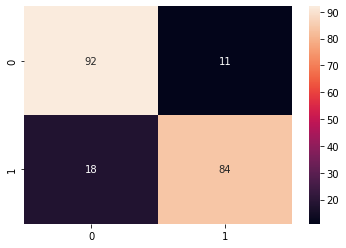

In [207]:
evaluate_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,64,64))


#### Final Result: Out of my first few experiments with this dataset, the best model accuracy score was 85.85% 
